In [1]:

import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import tables as tb
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
from sklearn.neighbors import BallTree, KDTree, DistanceMetric
import glob

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
train = pd.read_hdf('open30.h5') # pick just a single brick
test = pd.read_hdf('test.h5')

In [3]:
test = test.reset_index(drop=True)

In [4]:
test.head()

,TX,TY,X,Y,Z,data_ind
0,0.087240,0.119438,86536.218750,62988.312500,56892.0,0
1,-0.380208,0.198382,93346.765625,58062.937500,14223.0,0
2,-0.348549,-0.099981,66129.578125,23038.673828,46548.0,0
3,0.585342,-0.126879,68825.523438,55186.625000,45255.0,0
4,0.038579,-0.131510,36366.941406,47564.878906,9051.0,0


In [5]:
train.head()

,TX,TY,X,Y,Z,event_id,signal,data_ind
0,-0.248382,0.072824,37014.070312,38318.898438,31032.0,-999.0,0.0,21
1,0.768548,0.490205,46626.425781,15151.117188,72408.0,188918.0,1.0,21
2,-0.132050,-0.049405,54031.640625,69132.320312,60771.0,-999.0,0.0,21
3,0.260584,0.207106,56653.531250,35025.765625,43962.0,-999.0,0.0,21
4,0.267597,0.111272,42231.714844,47199.027344,20688.0,-999.0,0.0,21


Let's see how showers look like inside one data_ind

In [6]:
CMAP = sns.diverging_palette(220, 20, s=99, as_cmap=True, n=2500)

def plot3D(X, target, elev=0, azim=0, title=None, sub=111):
    x = X[:, 0]
    y = X[:, 1]
    z = X[:, 2]
    
    fig = plt.figure(figsize=(12, 8))
    ax = Axes3D(fig)
    mappab = ax.scatter(x, y, z, c=target, cmap=CMAP)

    if title is not None:
        ax.set_title(title)
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')

# Этот инструмент позволяет менять точку зрения
    ax.view_init(elev=elev, azim=azim)
    fig.colorbar(mappable=mappab, label='Target variable')
    plt.show()
    
feat_XY = ['TX', 'TY', 'X', 'Y']

In [7]:
first = train.loc[train.data_ind == 21, :]

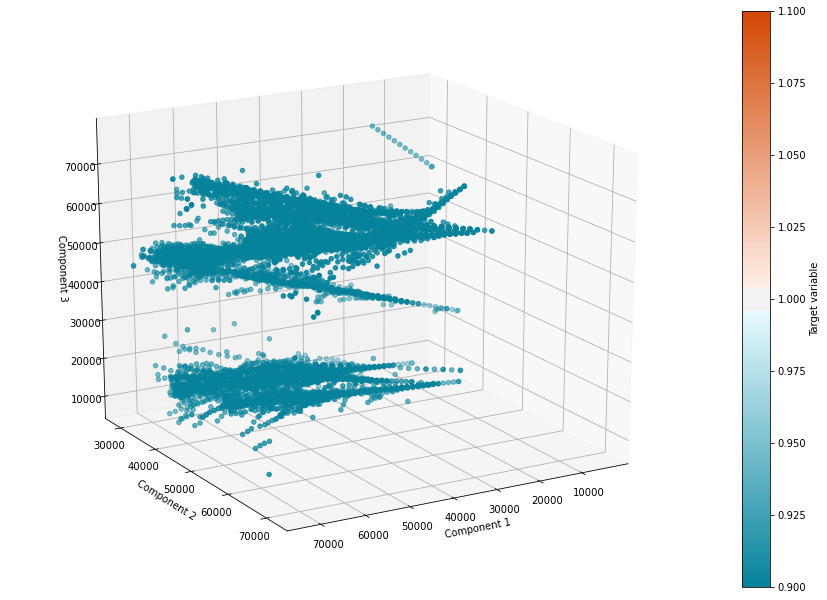

In [8]:
plot3D(first.loc[first.signal==1, ['Z', 'X', 'Y']].values,
       first.loc[first.signal==1].signal.values, elev=20, azim=60)

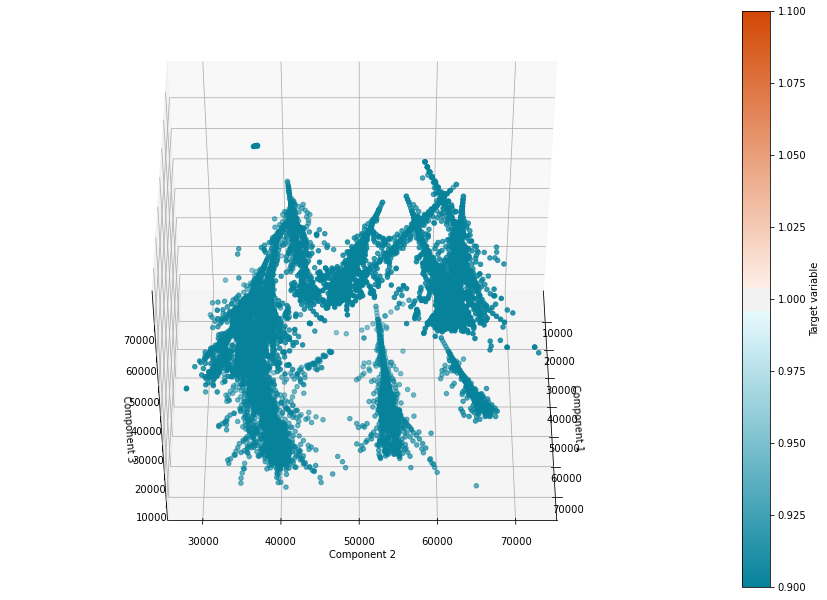

In [9]:
plot3D(first.loc[first.signal==1, ['Z', 'X', 'Y']].values,
       first.loc[first.signal==1].signal.values, elev=45, azim=0)

## Let's take a look at basetrack distribution along the axis

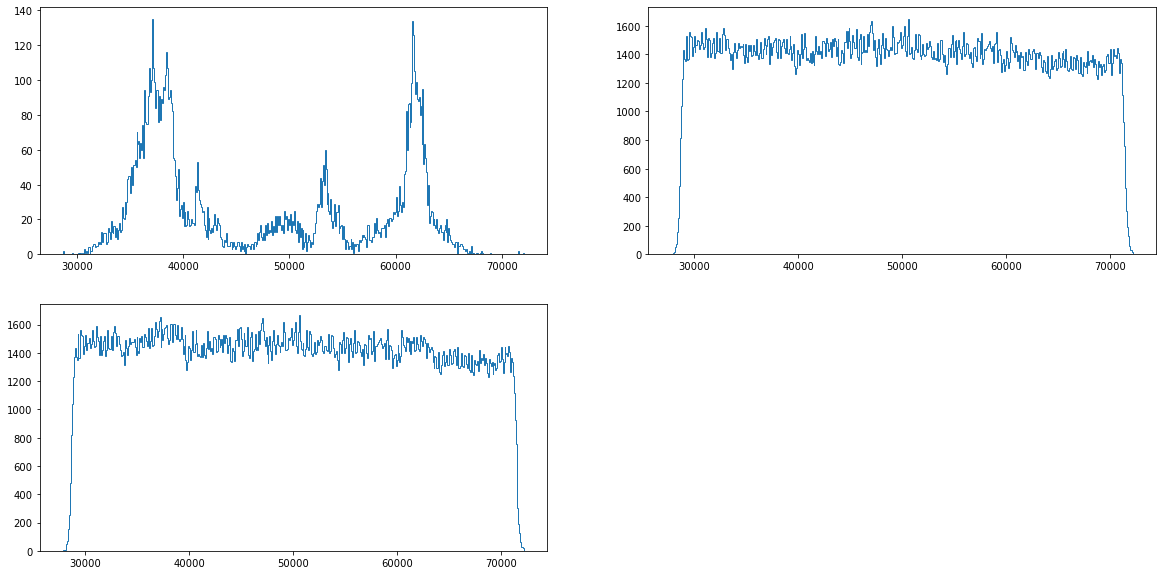

In [10]:
axis = 'X'

fig = plt.figure(figsize = [20, 10])
fig.add_subplot(221)
plt.hist(first.loc[first.signal == 1, axis], bins=500, histtype='step')
fig.add_subplot(222)
plt.hist(first.loc[first.signal == 0, axis], bins=500, histtype='step')
fig.add_subplot(223)
values_X = plt.hist(first.loc[:, axis], bins=500, histtype='step')
plt.show()

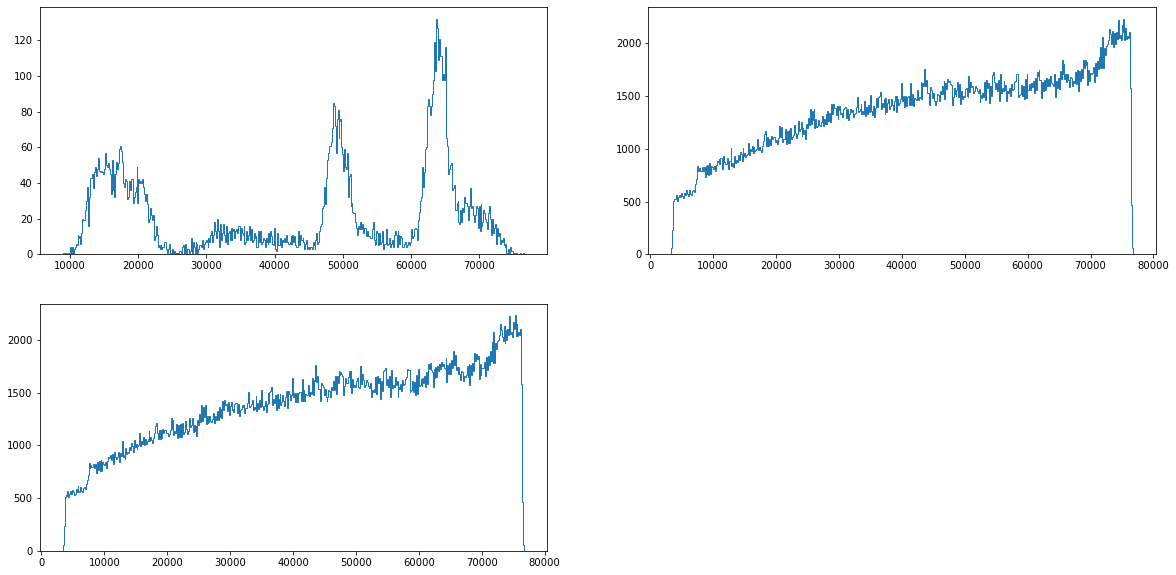

In [11]:
axis = 'Y'

fig = plt.figure(figsize = [20, 10])
fig.add_subplot(221)
plt.hist(first.loc[first.signal == 1, axis], bins=500, histtype='step')
fig.add_subplot(222)
plt.hist(first.loc[first.signal == 0, axis], bins=500, histtype='step')
fig.add_subplot(223)
values_X = plt.hist(first.loc[:, axis], bins=500, histtype='step')
plt.show()

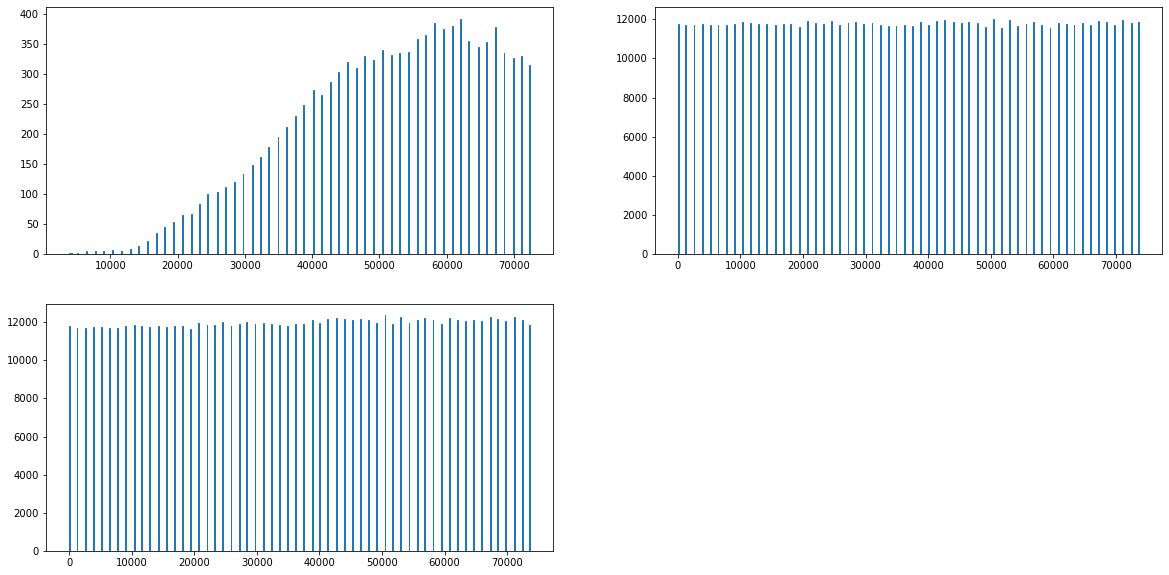

In [12]:
axis = 'Z'

fig = plt.figure(figsize = [20, 10])
fig.add_subplot(221)
plt.hist(first.loc[first.signal == 1, axis], bins=500, histtype='step')
fig.add_subplot(222)
plt.hist(first.loc[first.signal == 0, axis], bins=500, histtype='step')
fig.add_subplot(223)
values_X = plt.hist(first.loc[:, axis], bins=500, histtype='step')
plt.show()

In [13]:
def add_neighbours(df, k, metric='minkowski'):
    res = []
    
    for data_ind in tqdm(np.unique(df.data_ind)):
        ind = df.loc[df.data_ind == data_ind].copy()
        #как будет замечено, 1293 - это расстояние между слайсами по Z
        ind[['TX', 'TY']] *= 1293
        values = np.unique(ind.Z)
        
        for j in range(1, len(values)):
            z, z_next = (ind.loc[ind.Z == values[j-1]].copy(),
                         ind.loc[ind.Z == values[j]].copy())
            
            b_tree = BallTree(z_next[feat_XY], metric=metric)
            d, i = b_tree.query(z[feat_XY], k=min(k, len(z_next)))
            
            for m in range(i.shape[1]):
                data = z_next.iloc[i[:, m]]
                z_copy = z.copy()
                for col in feat_XY + ['Z']:
                    z_copy[col + '_pair'] = data[col].values
                res.append(z_copy)
            
        res.append(z_next)
        
    res = pd.concat(res, sort=True)
    for col in feat_XY + ['Z']:
        res['d' + col] = res[col].values - res[col + '_pair'].values
    return res

def balance_train(df, k):
    data = add_neighbours(df, k=k)
    noise = data.event_id == -999
    signal, not_signal = data.loc[np.logical_not(noise)], data.loc[noise]
    noise_part = not_signal.sample(len(signal))
    return pd.concat([signal, noise_part], sort=True).reset_index(drop=True)

In [14]:
train = []
for file in glob.glob('open*.h5')[:5]: # just 5 bricks
    train.append(balance_train(pd.read_hdf(file), k=3))
train = pd.concat(train, sort=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:47<00:00, 10.73s/it]


In [15]:
train.head()

,TX,TX_pair,TY,TY_pair,X,X_pair,Y,Y_pair,Z,Z_pair,dTX,dTY,dX,dY,dZ,data_ind,event_id,signal
0,-86.840851,-94.468147,92.664032,123.360336,47257.558594,47264.585938,11238.640625,11231.140625,5172.000000,5426.527344,7.627296,-30.696304,-7.027344,7.500000,-254.527344,261,183825.0,1.0
1,-94.468147,-89.869354,123.360336,99.934273,47264.585938,47168.984375,11231.140625,11332.085938,5426.527344,6465.000000,-4.598793,23.426064,95.601562,-100.945312,-1038.472656,261,183825.0,1.0
2,-94.468147,339.412476,123.360336,69.291908,47264.585938,47322.609375,11231.140625,11128.431641,5426.527344,6465.000000,-433.880615,54.068428,-58.023438,102.708984,-1038.472656,261,183825.0,1.0
3,-94.468147,275.844818,123.360336,159.851212,47264.585938,46879.843750,11231.140625,11431.775391,5426.527344,6465.000000,-370.312958,-36.490875,384.742188,-200.634766,-1038.472656,261,183825.0,1.0
4,-89.869354,-70.092018,99.934273,84.584602,47168.984375,47085.210938,11332.085938,11426.468750,6465.000000,7758.000000,-19.777336,15.349670,83.773438,-94.382812,-1293.000000,261,183825.0,1.0


# Building a model

In [16]:
y_train = train.signal
X_train = train.drop(['event_id', 'signal', 'data_ind'], axis=1)

In [17]:
# # import os

# # mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-7.2.0-posix-seh-rt_v5-rev1\\mingw64\\bin'

# # os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

# import xgboost as xg
# from xgboost import XGBClassifier
# from sklearn.model_selection import StratifiedKFold, GridSearchCV

In [18]:
# param_grid = {
#         'n_estimators':[10, 20], 
#         'max_depth':[15],
# }

# class XGBClassifier_tmp(XGBClassifier):
#     def predict(self, X):
#         return XGBClassifier.predict_proba(self, X)[:, 1]

# clf = GridSearchCV(XGBClassifier_tmp(learning_rate=0.05, subsample=0.8,
#                                      colsample_bytree=0.8, n_jobs=20), 
#                    param_grid=param_grid, n_jobs=3,
#                    scoring='roc_auc',
#                    cv=StratifiedKFold(3, shuffle=True, random_state=0),
#                    verbose=7)

In [19]:
# clf.fit(X_train, y_train)

In [20]:
# clf.best_estimator_

In [21]:
# xgb_class = XGBClassifier_tmp(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#          colsample_bytree=0.8, gamma=0, learning_rate=0.05,
#          max_delta_step=0, max_depth=15, min_child_weight=1, missing=None,
#          n_estimators=100, nthread=None,
#          objective='binary:logistic', random_state=0, reg_alpha=0,
#          reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
#          subsample=0.8, n_jobs=24)

In [22]:
from sklearn.preprocessing import Normalizer
transformer = Normalizer()
X_train_norm = transformer.fit_transform(X_train.fillna(0))

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend

Using TensorFlow backend.


In [24]:
def nn_model(input_dim):
    model = Sequential()
    model.add(Dense(256, input_dim=input_dim))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam())
    return model

In [25]:
callbacks = [EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto'),
            ModelCheckpoint('output/model.{val_loss:.4f}.hdf5', monitor='val_loss', verbose=2, save_best_only=True, mode='auto')]

In [26]:
nn = nn_model(X_train_norm.shape[1])
nn.fit(X_train_norm, y_train, validation_split=0.2, epochs=40, verbose=1, batch_size=512, shuffle=True, callbacks = callbacks)

Train on 3868520 samples, validate on 967130 samples
Epoch 1/40
3867648/3868520 [============================>.] - ETA: 0s - loss: 0.5740
Epoch 00001: val_loss improved from inf to 0.57557, saving model to output/model.0.5756.hdf5
3868520/3868520 [==============================] - 104s 27us/sample - loss: 0.5740 - val_loss: 0.5756
Epoch 2/40
3867648/3868520 [============================>.] - ETA: 0s - loss: 0.533 - ETA: 0s - loss: 0.5335
Epoch 00002: val_loss improved from 0.57557 to 0.49410, saving model to output/model.0.4941.hdf5
3868520/3868520 [==============================] - 101s 26us/sample - loss: 0.5335 - val_loss: 0.4941
Epoch 3/40
3867648/3868520 [============================>.] - ETA: 0s - loss: 0.5027
Epoch 00003: val_loss improved from 0.49410 to 0.47694, saving model to output/model.0.4769.hdf5
3868520/3868520 [==============================] - 100s 26us/sample - loss: 0.5027 - val_loss: 0.4769
Epoch 4/40
3866112/3868520 [============================>.] - ETA: 0s - los

# Prediction

In [27]:
prepared_test = add_neighbours(test, k=3)
X_test = prepared_test.drop(['data_ind'], axis=1)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [01:42<00:00,  9.32s/it]


In [28]:
X_test_norm = transformer.transform(X_test.fillna(0))

In [29]:
probas = nn.predict_proba(X_test_norm)

In [30]:
probas = np.squeeze(probas)

In [31]:
df = pd.DataFrame({'id': prepared_test.index, 'signal': probas}).groupby('id')
agg = df.aggregate(('mean')).loc[:, ['signal']]

In [32]:
agg.shape

(7698899, 1)

In [33]:
agg.head()

,signal
id,
0,0.373059
1,0.007771
2,0.308802
3,0.265889
4,0.010572
